In [9]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install spotipy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install python-dotenv


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [84]:
from matplotlib import pyplot
from matplotlib.figure import Figure
import spotipy
import json
import io
import pandas as pd


class Reader():
    def __init__(self, spotify: spotipy.Spotify, track: str = "spotify:track:0Kx3zOgcppxtSl1LJNAZml") -> None:
        self.spotify = spotify
        self.track = track

    def get_notes(self):
        audio_info = self.spotify.audio_analysis(self.track)
        song = pd.DataFrame(columns=['timbre', 'pitch'])
        segments = audio_info["segments"]
        note_index = 0
        for index in range(len(segments)):
            if segments[index]["confidence"] < 0.7:
                continue
            if segments[index]["duration"] < 0.1:
                continue
            pitches = segments[index]["pitches"]
            timbre = segments[index]["timbre"]
            for note in range(len(pitches)):
                song.loc[note_index] = [timbre[note], pitches[note]]
                note_index += 1
        return song



In [85]:
from spotipy.oauth2 import SpotifyClientCredentials
import os
from dotenv import load_dotenv

load_dotenv()

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

In [86]:
reader = Reader(spotify)
air = reader.get_notes()
air

,timbre,pitch
0,21.067,0.021
1,-3.441,0.043
2,64.076,1.000
3,-146.661,0.157
4,116.761,0.131
...,...,...
3211,67.471,0.006
3212,-11.228,0.014
3213,6.969,1.000
3214,-57.576,0.009


In [87]:
def scatter_value(song, noise):
    pyplot.figure(figsize=(10, 8))
    pyplot.scatter(range(len(song[noise])),song[noise])
    pyplot.show()

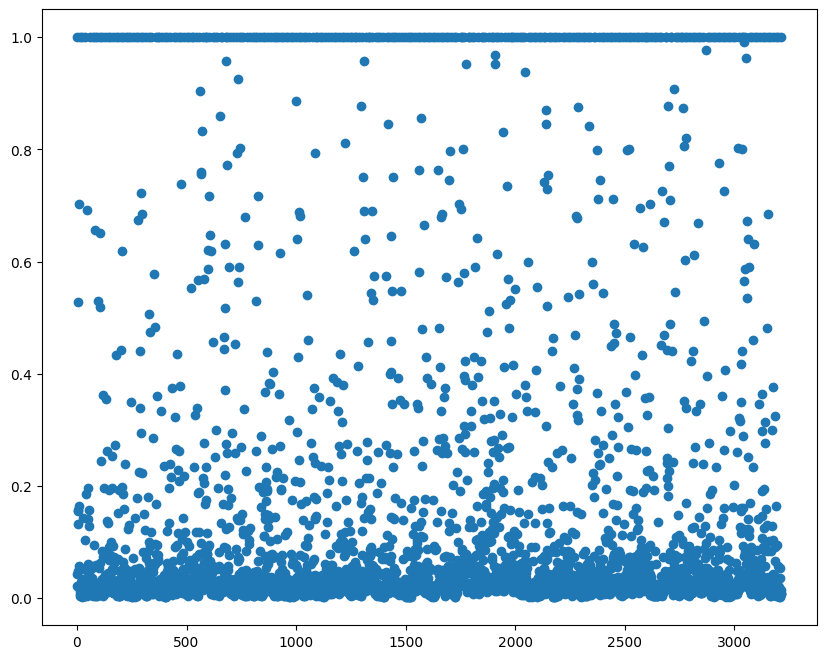

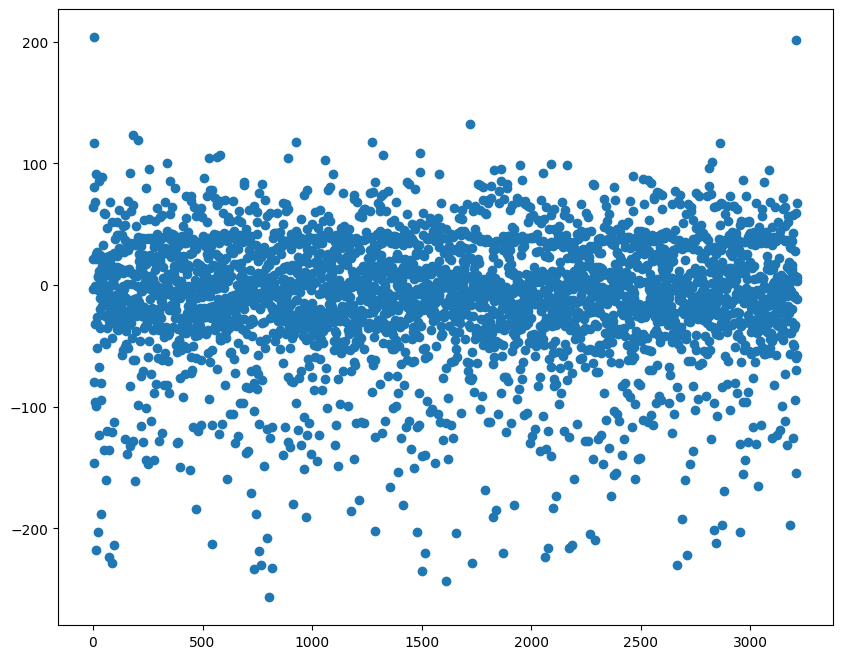

In [88]:
scatter_value(air, "pitch")
scatter_value(air, "timbre")

In [89]:
reader_vivaldi = Reader(spotify, "spotify:track:4jOlYUMMsCacMm3xcrYRLl")
spring = reader_mozart.get_notes()

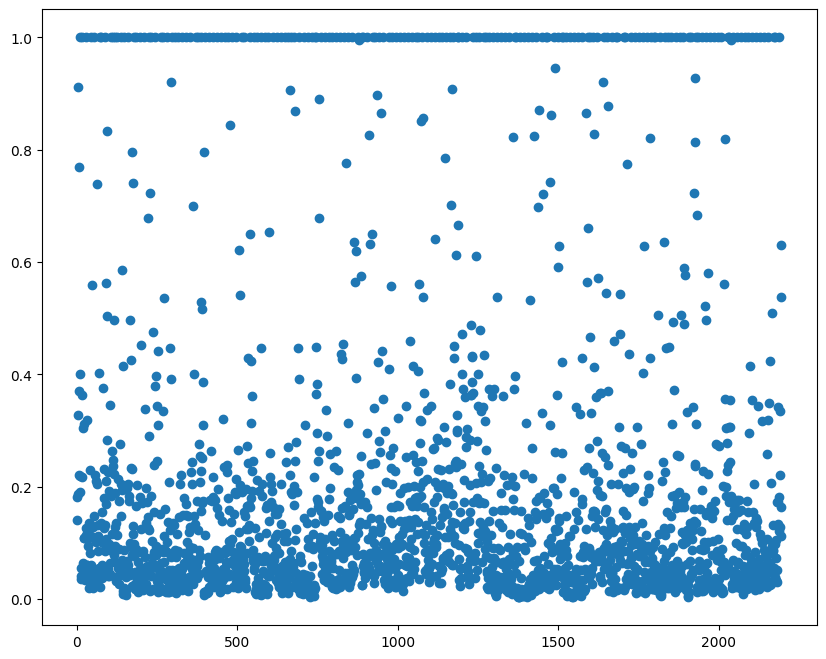

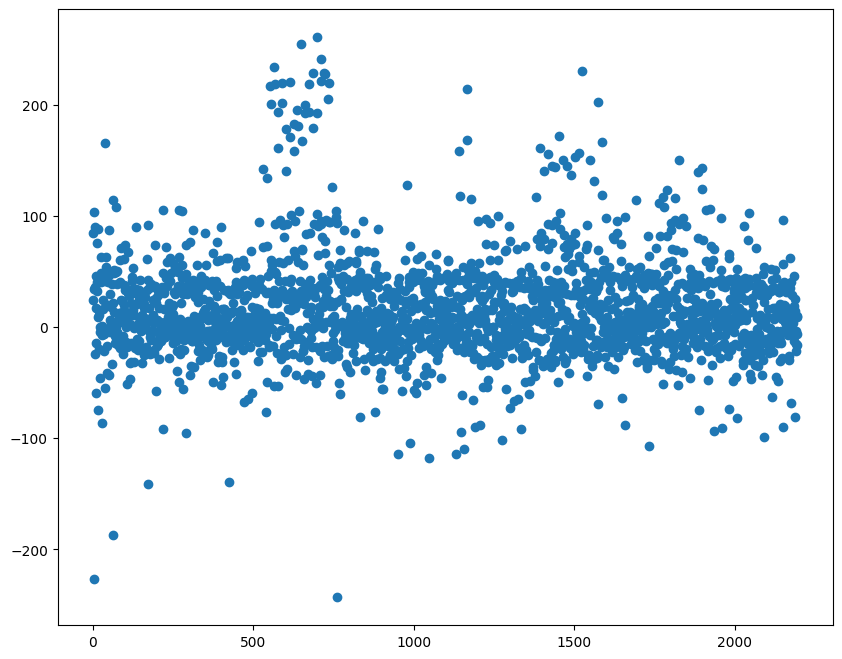

In [90]:
scatter_value(spring,"pitch")
scatter_value(spring, "timbre")

Text(0, 0.5, 'SPRING Timbre')

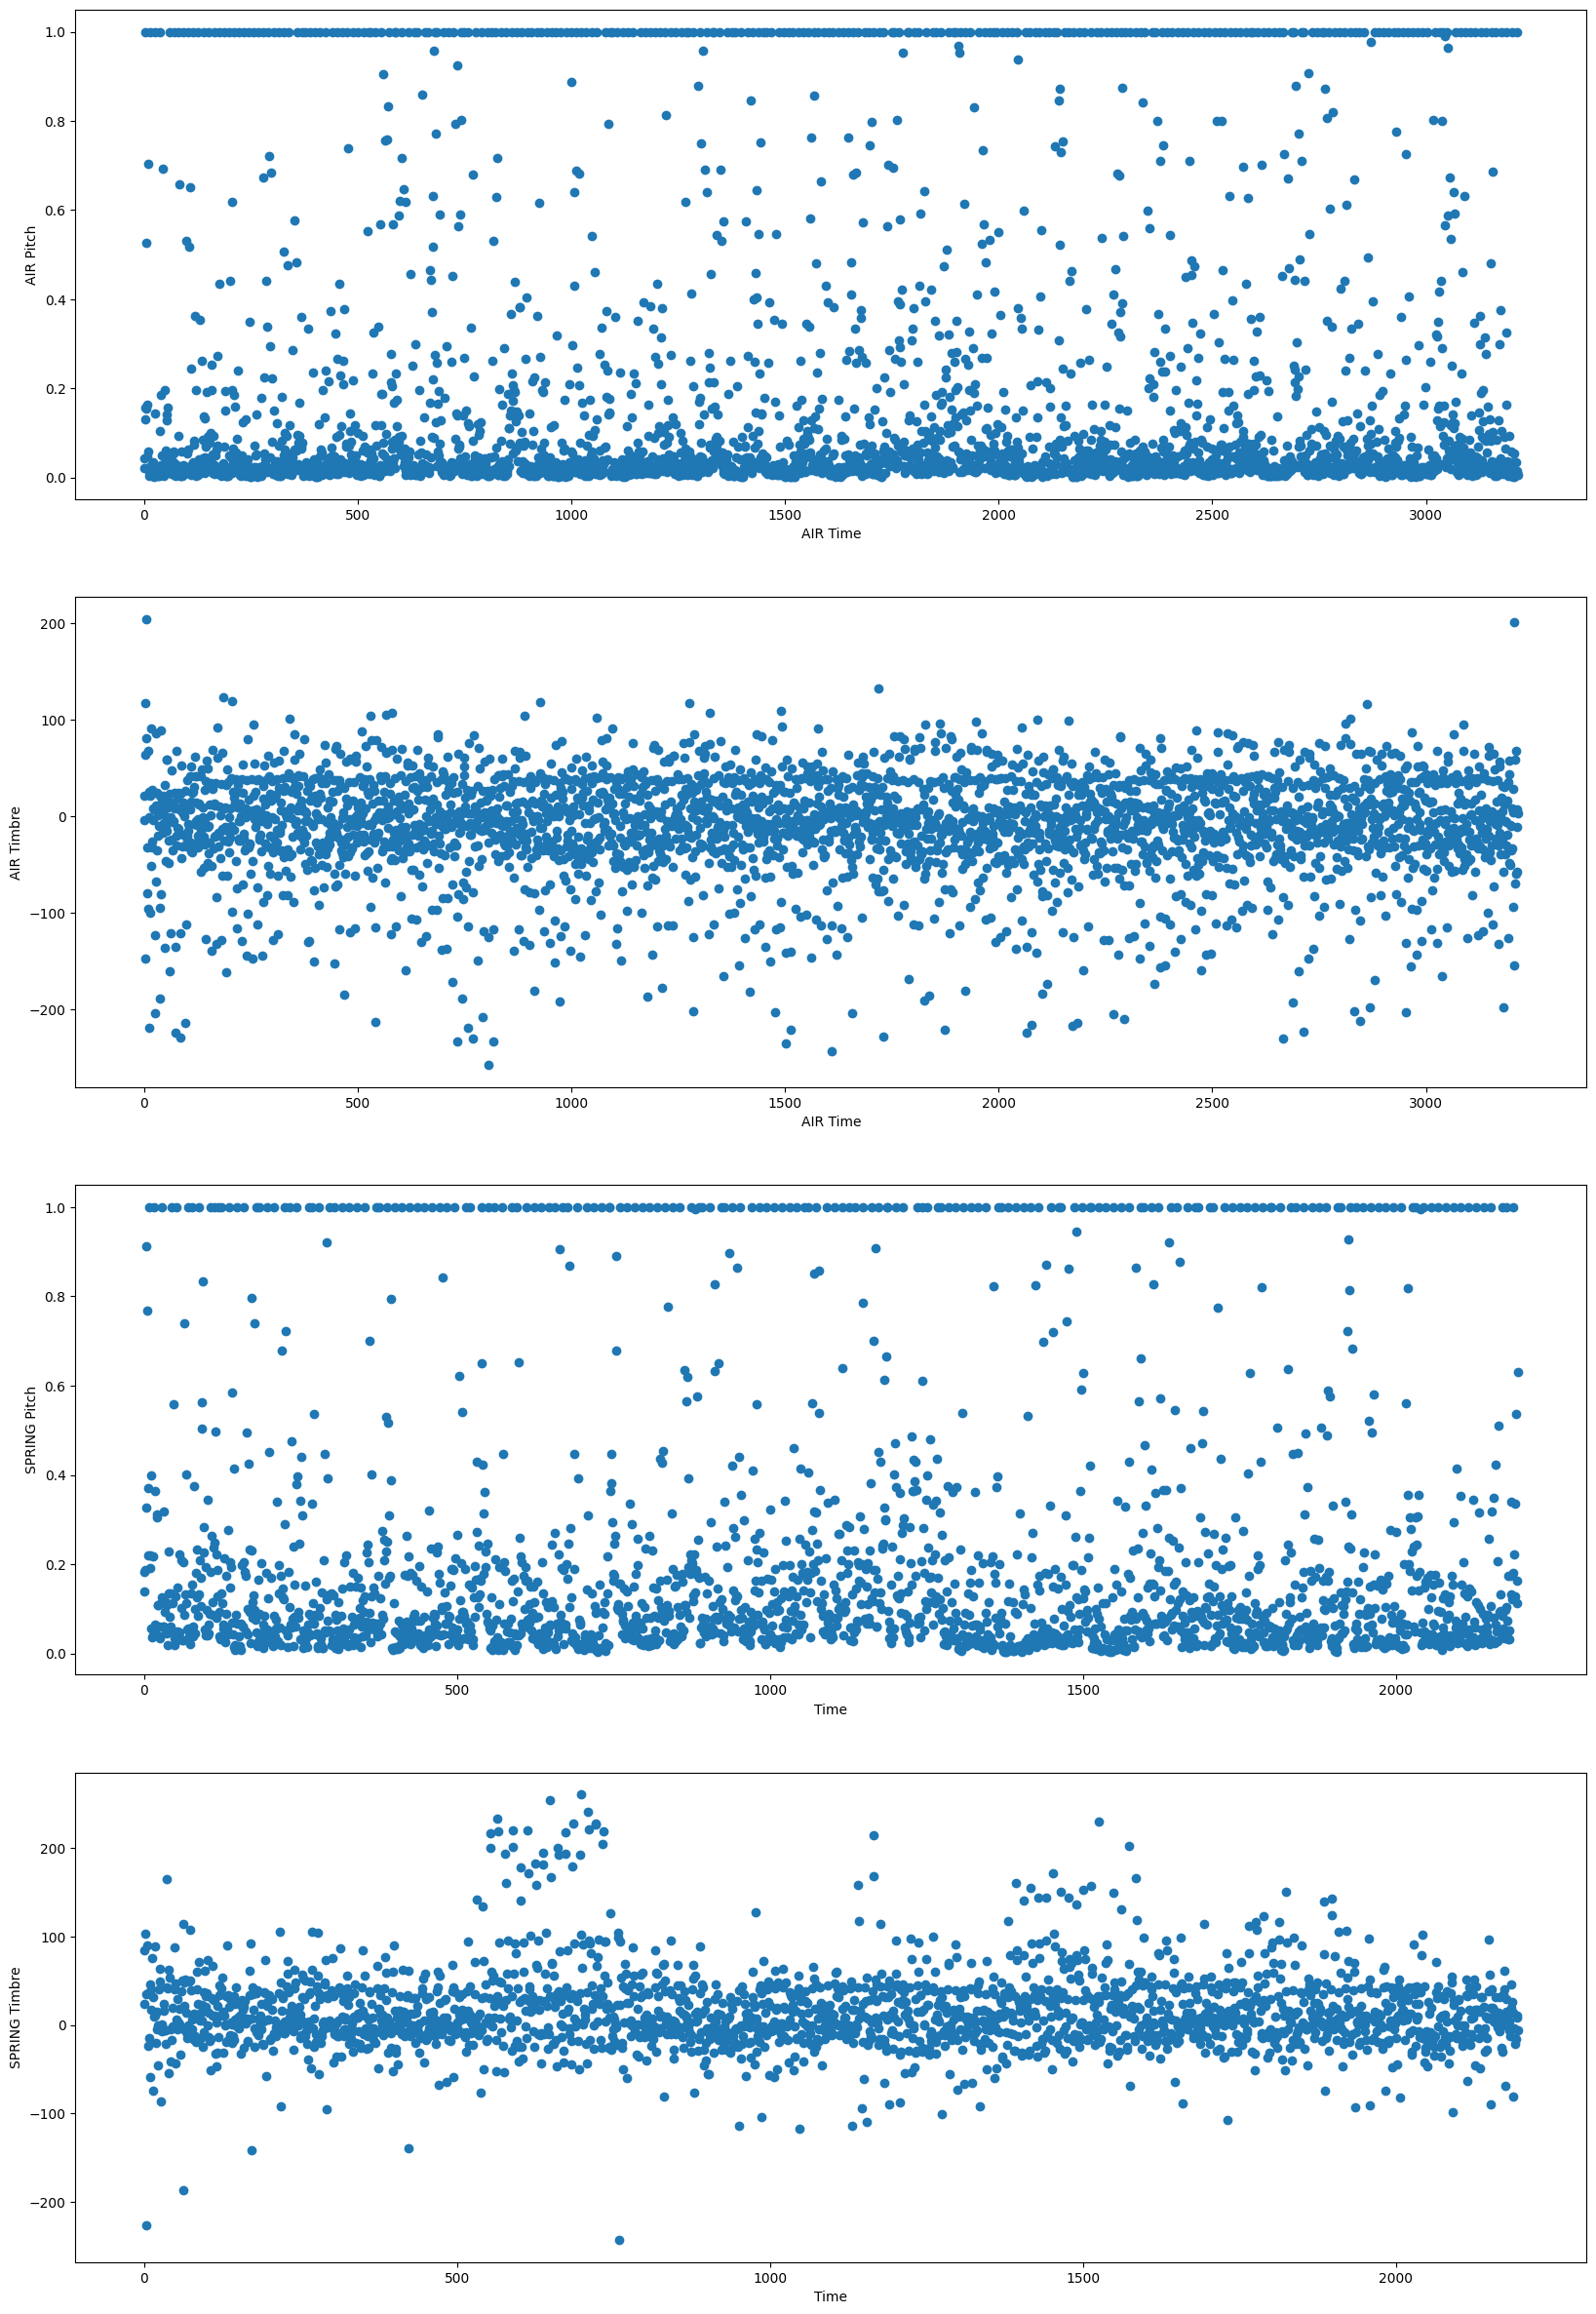

In [91]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, figsize=(20, 30))
ax[0].scatter(range(len(air["pitch"])),air["pitch"])
ax[0].set_xlabel("AIR Time")
ax[0].set_ylabel("AIR Pitch")

ax[1].scatter(range(len(air["timbre"])),air["timbre"])
ax[1].set_xlabel("AIR Time")
ax[1].set_ylabel("AIR Timbre")

ax[2].scatter(range(len(spring["pitch"])),spring["pitch"])
ax[2].set_xlabel("Time")
ax[2].set_ylabel("SPRING Pitch")

ax[3].scatter(range(len(spring["timbre"])),spring["timbre"])
ax[3].set_xlabel("Time")
ax[3].set_ylabel("SPRING Timbre")


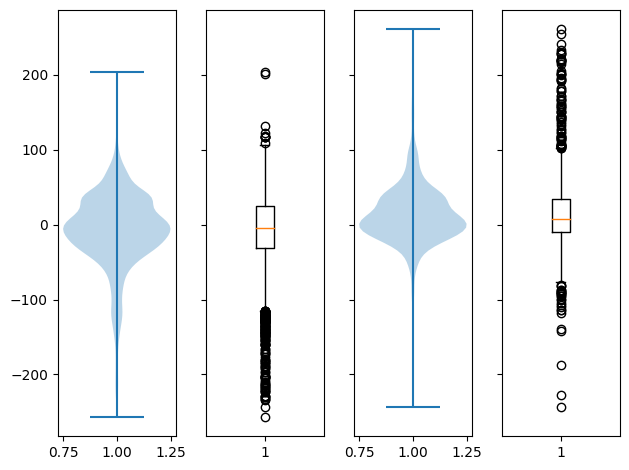

In [92]:
fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)
n_bins = 30
# We can set the number of bins with the *bins* keyword argument.

air_violin = axs[0].violinplot(air["timbre"])
air_box = axs[1].boxplot(air["timbre"])

spring_violin = axs[2].violinplot(spring["timbre"])
spring_box = axs[3].boxplot(spring["timbre"])


In [130]:
import numpy

def plot_box_and_violin(song: pd.DataFrame, noise: str, title: str):
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.violinplot(song[noise])
    box = plt.boxplot(song[noise])
    plt.show()
    box_qs = numpy.unique([item.get_ydata() for item in box['boxes']])
    box_whiskers = [item.get_ydata()[1] for item in box["whiskers"]]
    print(f"Bottom whisker: {box_whiskers[0]} \nTop whisker: {box_whiskers[1]}")
    print(f"Q1: {box_qs[0]} \nQ3: {box_qs[1]}")
    return box

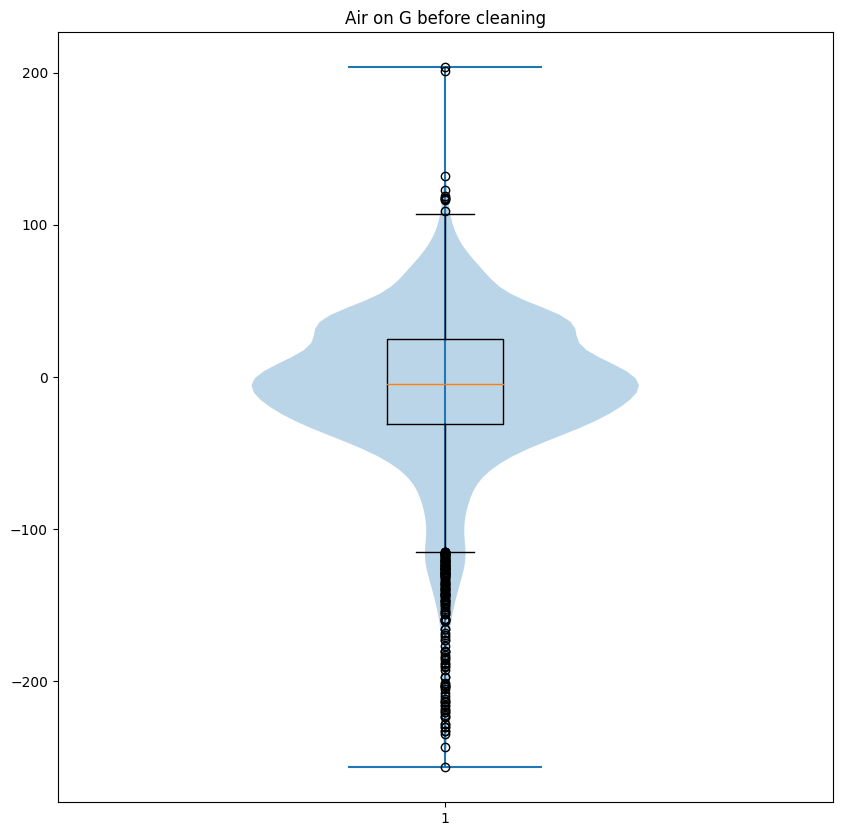

Bottom whisker: -115.166 
Top whisker: 106.883
Q1: -31.18525 
Q3: 24.8065


In [131]:
air_box = plot_box_and_violin(air, "timbre", "Air on G before cleaning")

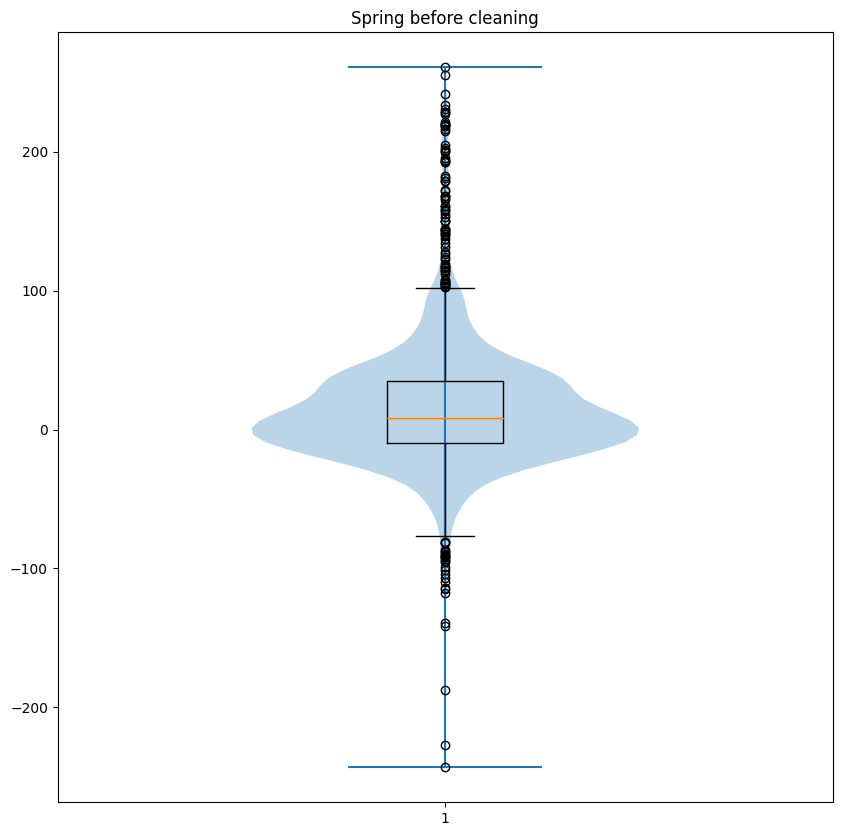

Bottom whisker: -76.769 
Top whisker: 101.765
Q1: -10.031749999999999 
Q3: 34.881249999999994


In [132]:
spring_box = plot_box_and_violin(spring, "timbre", "Spring before cleaning")

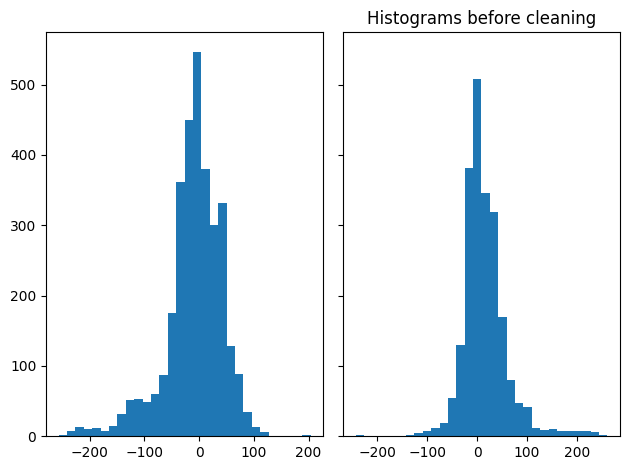

In [133]:
def create_histograms(compared_to: pd.DataFrame, compared_with: pd.DataFrame, noise: str, title: str, bins: int):
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    plt.title(title)
    axs[0].hist(compared_to[noise], bins=bins)
    axs[1].hist(compared_with[noise], bins=bins)

create_histograms(air, spring, "timbre", "Histograms before cleaning", 30)

## Cleaning up
We can easily round up those values to be honest <br>
Piano has 88 keys <br>
Those timbre values have ~ 400 values range <br>
Lets do that, yeah, we don't need .0001 values at all <br>
Differences are definitely unhearable <br>

## Rounding

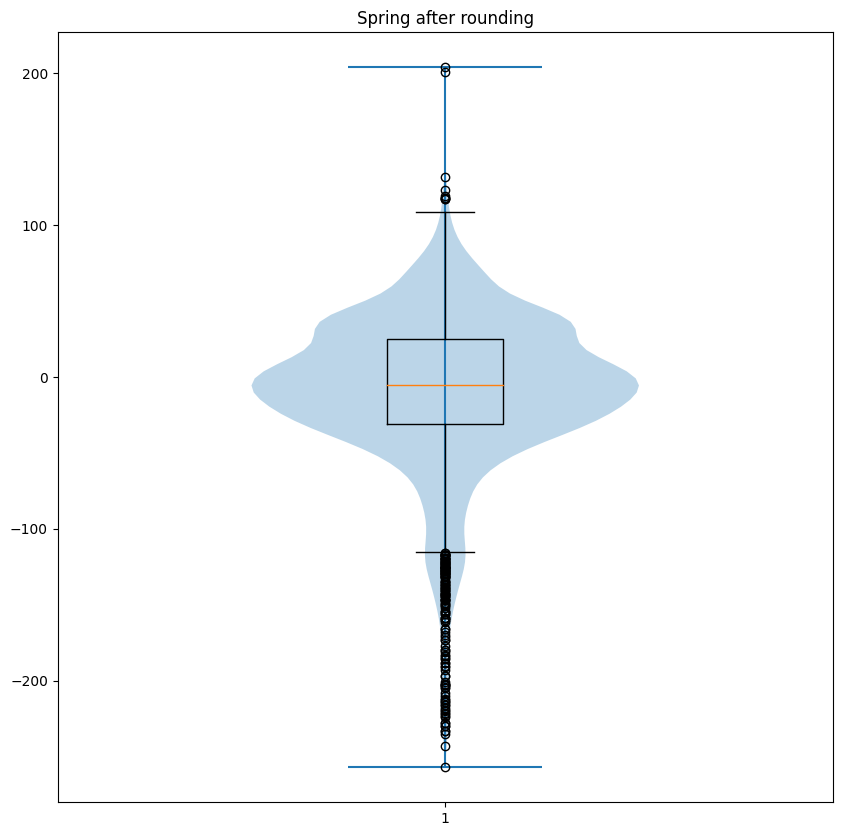

Bottom whisker: -115.0 
Top whisker: 109.0
Q1: -31.0 
Q3: 25.0


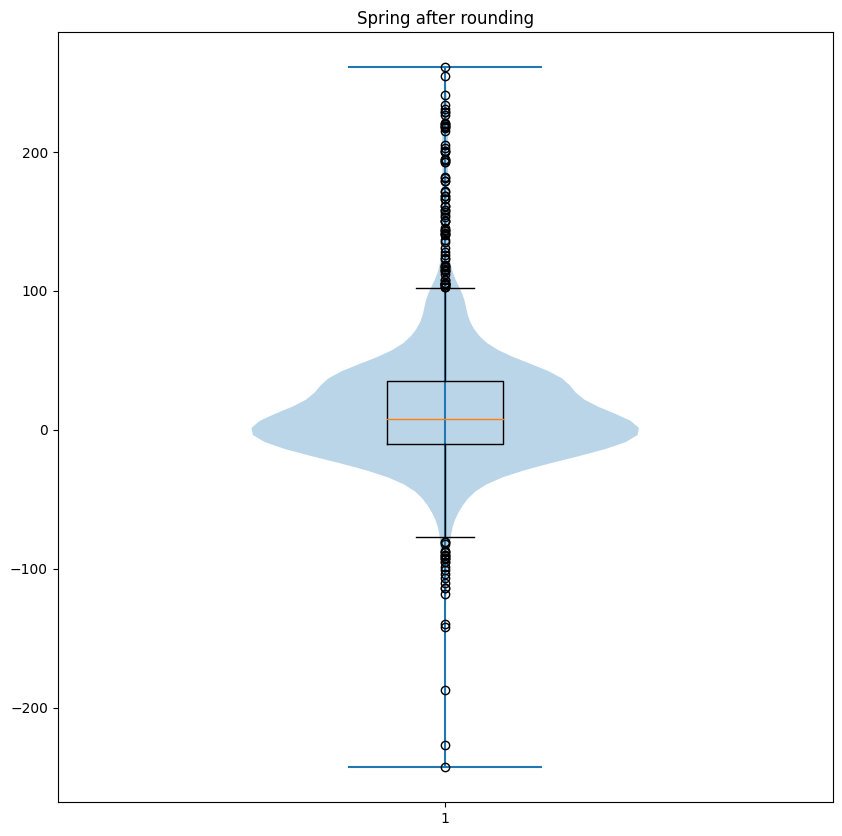

Bottom whisker: -77.0 
Top whisker: 102.0
Q1: -10.0 
Q3: 35.0


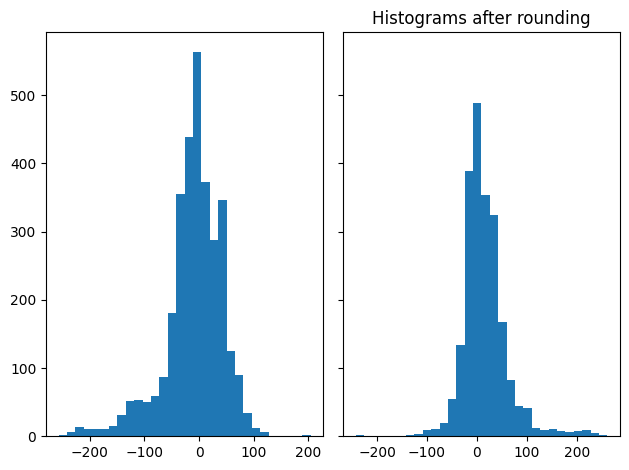

In [134]:
air_box = plot_box_and_violin(air.round(), "timbre", "Spring after rounding")
spring_box = plot_box_and_violin(spring.round(), "timbre", "Spring after rounding")

create_histograms(air.round(), spring.round(), "timbre", "Histograms after rounding", 30)

## Removing outliers

In [180]:
air["timbre"].quantile(0.01)

-196.42765000000003

In [198]:
def remove_outliers(song: pd.DataFrame, column:str , quantile: float = 0.01):
    filter_top = song[column].quantile(1.0-quantile)
    filtered_top = song[song[column] < filter_top]
    filter_bottom = song[column].quantile(quantile)
    filtered_both = filtered_top[filtered_top[column] > filter_bottom]
    return filtered_both

In [204]:
air_cleaned = remove_outliers(air, "timbre", 0.02).round()
spring_cleaned = remove_outliers(spring, "timbre", 0.02).round()

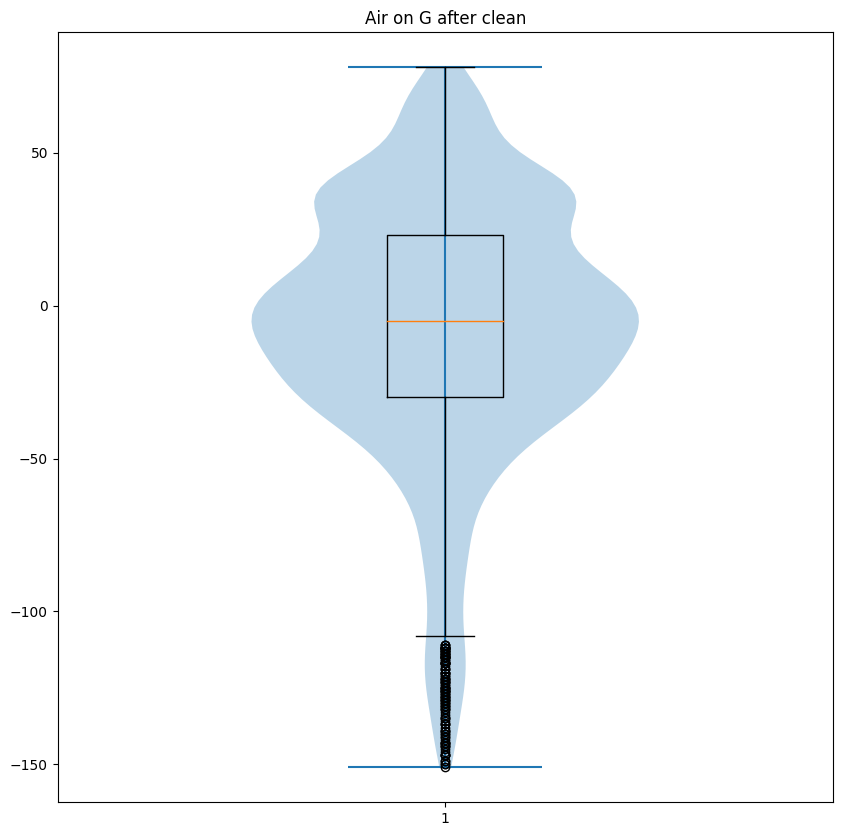

Bottom whisker: -108.0 
Top whisker: 78.0
Q1: -30.0 
Q3: 23.0


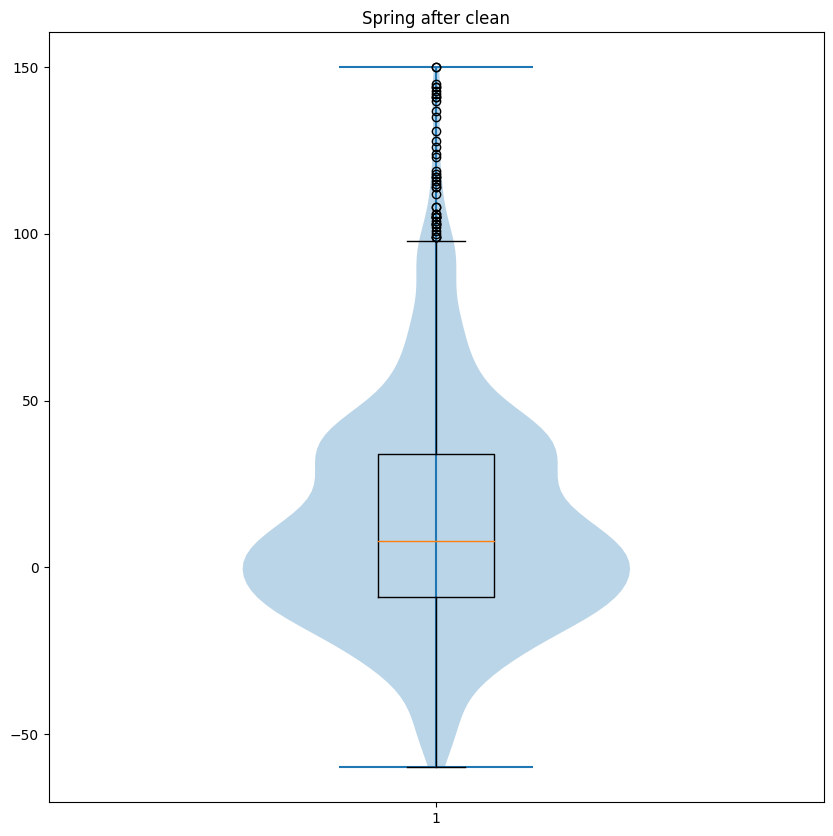

Bottom whisker: -60.0 
Top whisker: 98.0
Q1: -9.0 
Q3: 34.0


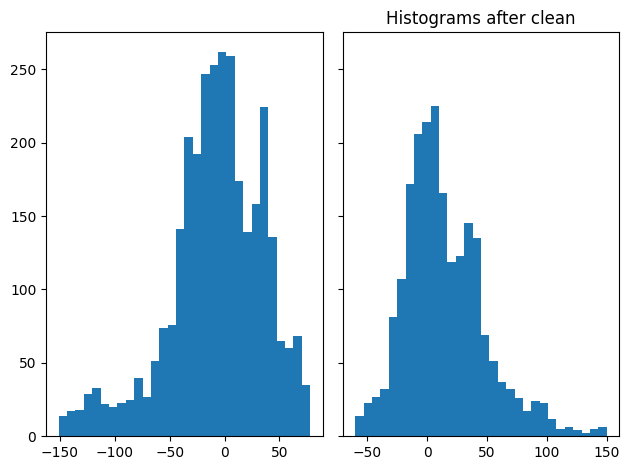

In [205]:
air_cleaned_box = plot_box_and_violin(air_cleaned, "timbre", "Air on G after clean")
spring__cleaned_box = plot_box_and_violin(spring_cleaned, "timbre", "Spring after clean")

create_histograms(air_cleaned, spring_cleaned, "timbre", "Histograms after clean", 30)

In [206]:
## Comparing those two

Text(0.5, 1.0, 'Spring clean')

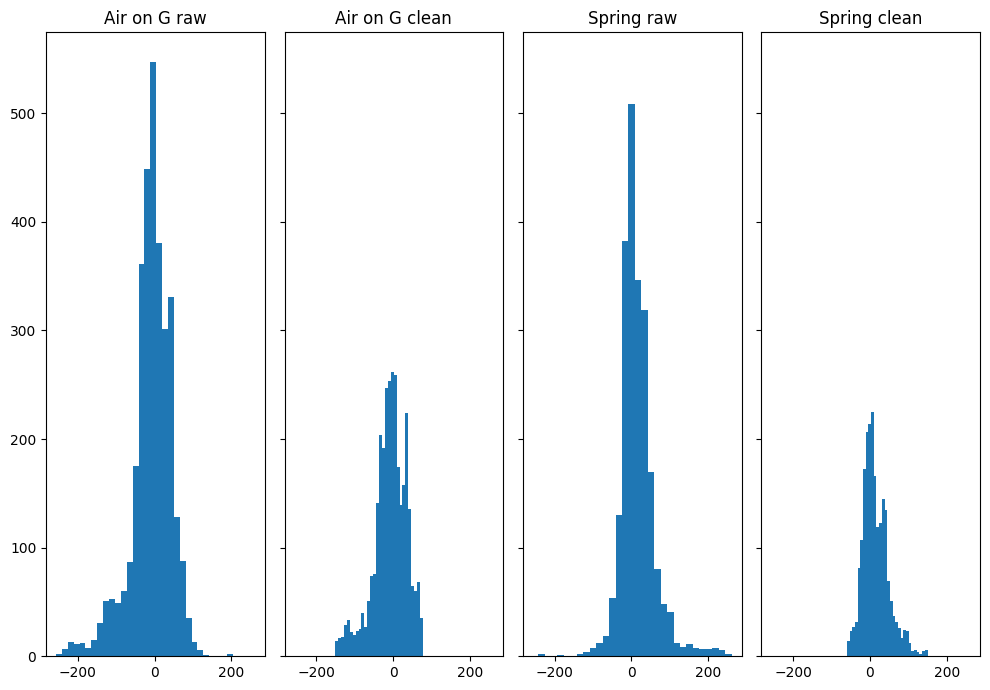

In [213]:
fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True,figsize=(10, 7), sharex=True)
bins = 30

axs[0].hist(air["timbre"], bins=bins)
axs[0].set_title("Air on G raw")

axs[1].hist(air_cleaned["timbre"], bins=bins)
axs[1].set_title("Air on G clean")

axs[2].hist(spring["timbre"], bins=bins)
axs[2].set_title("Spring raw")

axs[3].hist(spring_cleaned["timbre"], bins=bins)
axs[3].set_title("Spring clean")


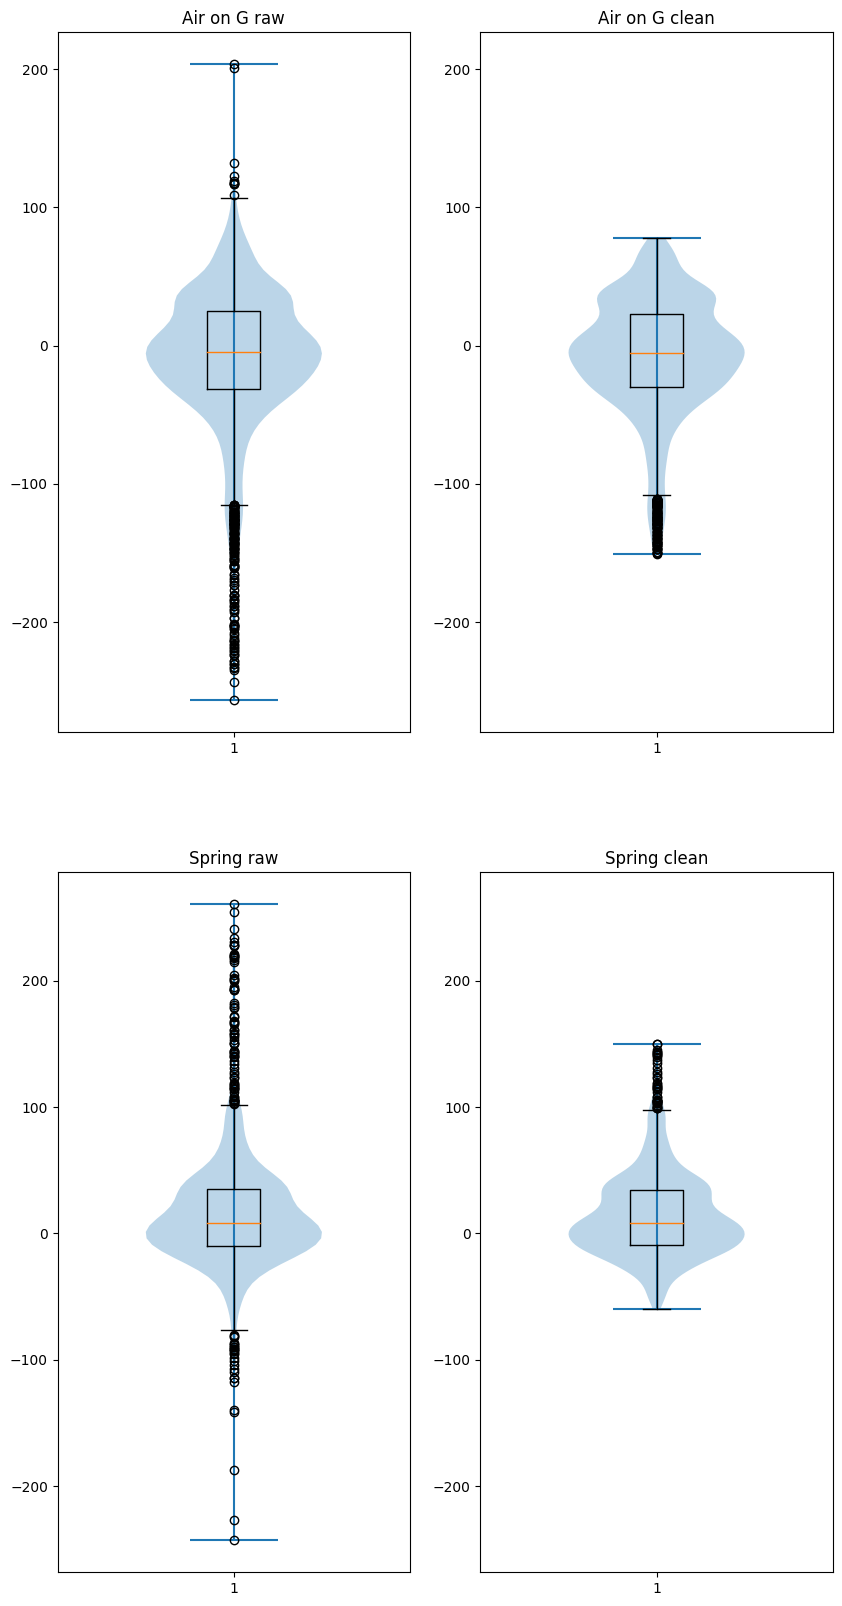

In [214]:
fig = plt.figure(figsize=(10,20))

ax_air = fig.add_subplot(2,2,1)
ax_air.set_title("Air on G raw")
plt.violinplot(air["timbre"])
box = plt.boxplot(air["timbre"])

ax = fig.add_subplot(2,2,2, sharey=ax_air)
ax.set_title("Air on G clean")
plt.violinplot(air_cleaned["timbre"])
box = plt.boxplot(air_cleaned["timbre"])

ax_spring = fig.add_subplot(2,2,3)
ax_spring.set_title("Spring raw")
plt.violinplot(spring["timbre"])
box = plt.boxplot(spring["timbre"])

ax = fig.add_subplot(2,2,4, sharey=ax_spring)
ax.set_title("Spring clean")
plt.violinplot(spring_cleaned["timbre"])
box = plt.boxplot(spring_cleaned["timbre"])
plt.show()

**Histogram makes sense.** <br>
'Air on G' is played on the G string, the lowest string on violin. <br>
On the other hand, 'Spring' is played on E string, which is the fourth, last string on violin. <br>